In [189]:
# load packages
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix, recall_score, accuracy_score, \
    precision_score, f1_score, confusion_matrix, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import itertools
import seaborn as sb
import time

In [19]:
def unzip():
    '''
        unzip test and train data from the Airline_Passenger_Satisfaction zip file
    '''
    zip = zipfile.ZipFile('Airline_Passenger_Satisfaction_dataset.zip')
    zip.extractall()

In [17]:
def load_data(train_data_dir, test_data_dir):
    ''' 
        train_data_dir: train data
        test_data_dir: test data
        return: df - dataframe for test and train data
    '''
    df1 = pd.read_csv(train_data_dir)
    df2 = pd.read_csv(test_data_dir)
    df = pd.concat([df1, df2])
    #id is not a feature, just a way to track user input
    df.drop('id', axis=1, inplace=True)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df 

In [6]:
def load_seperate_data(train_data_dir, test_data_dir):
    ''' 
        train_data_dir: train data
        test_data_dir: test data
        return: df1, df2 - separate dataframe for test and train
    '''
    df1 = pd.read_csv(train_data_dir)
    df2 = pd.read_csv(test_data_dir)
    #id is not a feature, just a way to track user input
    df1.drop('id', axis=1, inplace=True)
    df1.drop('Unnamed: 0', axis=1, inplace=True)
    df2.drop('id', axis=1, inplace=True)
    df2.drop('Unnamed: 0', axis=1, inplace=True)
    return df1, df2

In [7]:
def normalize_data(data_dir):
    ''' 
        data: input features
        labels: output features
    '''
    data, labels = load_data(data_dir)
    new_data = np.zeros(data.shape)
    for feature in range(data.shape[1]):
        feature_v = data[:, feature]
        feature_v = (feature_v - feature_v.min()) / (feature_v.max() - feature_v.min())
        new_data[:, feature] = feature_v
    return data, labels

In [119]:
# load the train and test data into dataframe
airplaine_sat_df = load_data("train.csv", "test.csv")
airplaine_sat_df.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [31]:
# shape of dataframe
airplaine_sat_df.shape

(129880, 23)

In [32]:
# information about features and labels
airplaine_sat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    12988

In [33]:
# statistical information about the data frame
airplaine_sat_df.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [35]:
# find empty cell in dataframe - found empty cells in 'Arrival Delay in Minutes'
np.where(pd.isnull(airplaine_sat_df))

(array([   213,   1124,   1529,   2004,   2108,   2485,   2630,   3621,
          4041,   4490,   4588,   4688,   4897,   5295,   5296,   5496,
          6947,   7225,   8035,   8421,   8933,   9060,   9481,   9531,
          9551,   9940,  10634,  10880,  12036,  12689,  12808,  13501,
         14185,  14301,  15223,  15371,  15683,  15860,  16132,  16329,
         16503,  16881,  17234,  17808,  18429,  18620,  18724,  18796,
         18871,  19498,  19971,  20049,  20665,  21453,  21794,  22202,
         22840,  22939,  22986,  23033,  23505,  24180,  26131,  26310,
         26338,  26605,  26913,  27135,  27238,  27261,  27279,  27618,
         27819,  27904,  27916,  27992,  28352,  28494,  28959,  29486,
         29918,  30504,  30529,  32197,  32558,  32864,  32916,  33056,
         33059,  33271,  33470,  33870,  33937,  34140,  34464,  34677,
         34727,  34837,  34841,  35248,  35267,  35271,  35309,  35340,
         35501,  35892,  35959,  36064,  36319,  36535,  37095, 

In [22]:
def feature_stats():
    ''' 
        Creates disrtubtion graphs for the features which are categorical
    '''
    df = load_data("train.csv", "test.csv")
    classes = df['satisfaction'].unique()
    df_pos =df.loc[df['satisfaction'] == classes[0]]
    df_neg =df.loc[df['satisfaction'] == classes[1]]
    feature_names = list(df.columns)
    feature_names.remove('satisfaction')
    category_features = []
    for feature in feature_names:
        feature_categories = df[feature].unique()
        
        x = np.arange(len(feature_categories))  # the label locations
        width = 0.35  # the width of the bars

        #if there are more than 10 inputs, probably not categorical and not work looking into
        #for this kind of inital analysis
        postive_counts = []
        negative_counts = []
        if len(feature_categories) <= 10:

            category_features.append(feature)
            if not isinstance(feature_categories, int):
                feature_categories.sort()
            for feature_cat in feature_categories:
                if feature_cat in df_pos[feature].unique():
                    postive_counts.append(df_pos[feature].value_counts()[feature_cat])
                else:
                    postive_counts.append(0)
                if feature_cat in df_neg[feature].unique():
                    negative_counts.append(df_neg[feature].value_counts()[feature_cat])
                else:
                    negative_counts.append(0)


            fig, ax = plt.subplots()
            rects1 = ax.bar(x - width/2, postive_counts, width, label=classes[0])
            rects2 = ax.bar(x + width/2, negative_counts, width, label=classes[1])

            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('Number of Data Instances')
            ax.set_title('Category Counts of {} Feature by Satisfaction Class'.format(feature))
            ax.set_xticks(x)
            ax.set_xticklabels(feature_categories)
            ax.legend()

            fig.tight_layout()
            title = feature.replace("/", "_")
            plt.savefig("feature_{}_category_distrubtions.png".format(title))
    print(category_features)

## Distribution for Feature Category by Satisfaction Class

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']


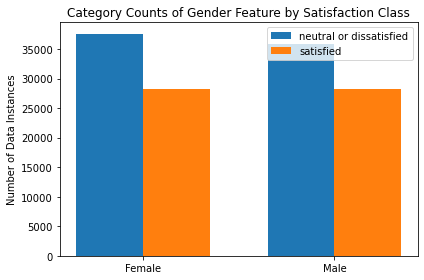

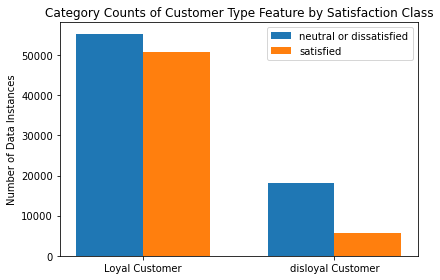

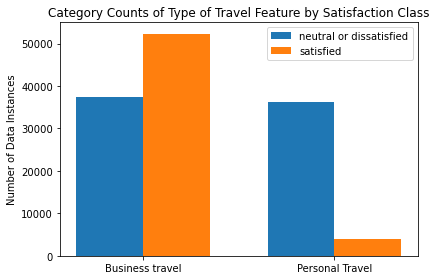

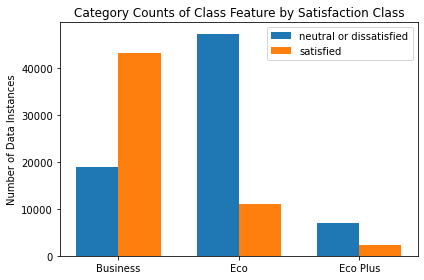

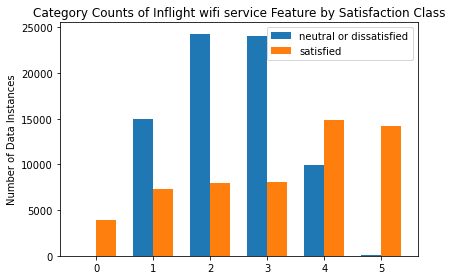

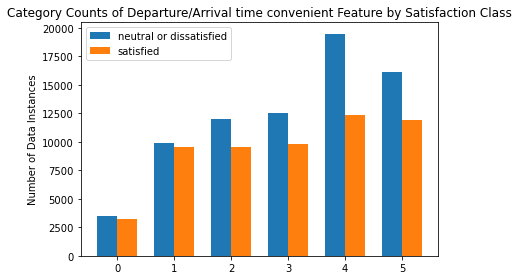

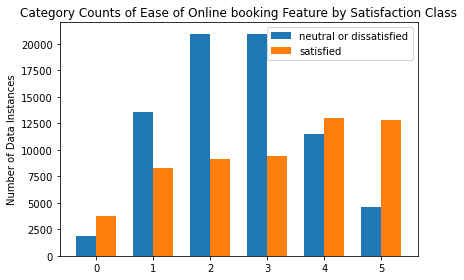

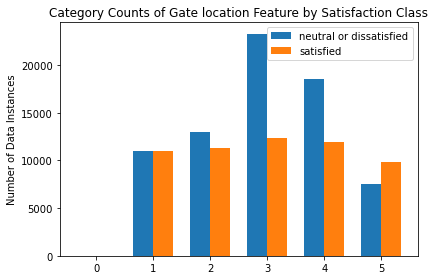

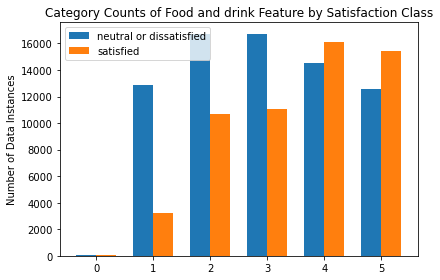

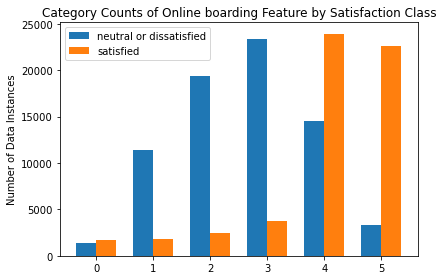

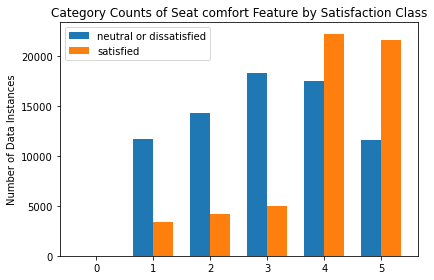

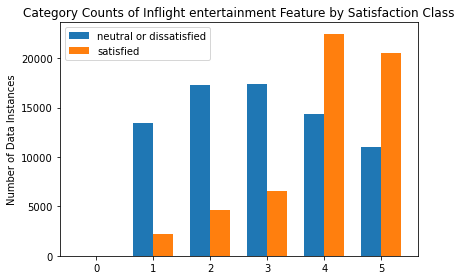

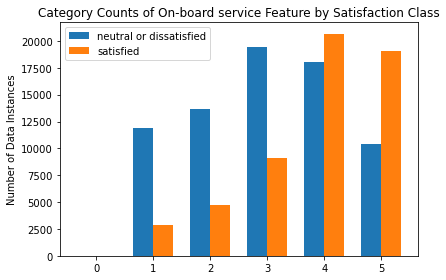

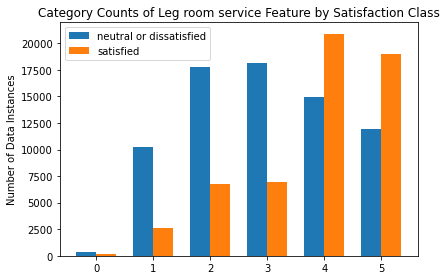

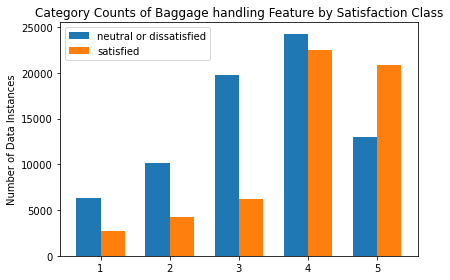

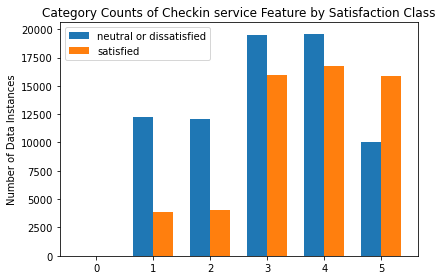

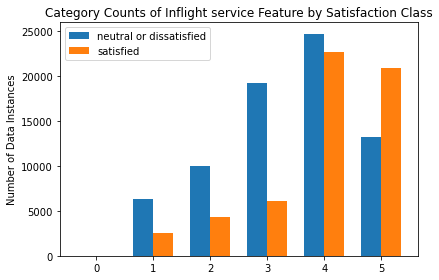

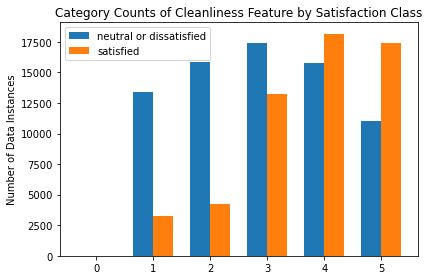

In [25]:
# show distributions for each feature category
feature_stats()

In [120]:
# fill NaN with average values of the column
airplaine_sat_df.fillna(airplaine_sat_df['Arrival Delay in Minutes'].median(), inplace=True)
np.where(pd.isnull(airplaine_sat_df))

(array([], dtype=int64), array([], dtype=int64))

In [121]:
# change data type of these columns to categorical
airplaine_sat_df['Gender'] = airplaine_sat_df['Gender'].astype('category')
airplaine_sat_df['Customer Type'] = airplaine_sat_df['Customer Type'].astype('category')
airplaine_sat_df['Type of Travel'] = airplaine_sat_df['Type of Travel'].astype('category')
airplaine_sat_df['Class'] = airplaine_sat_df['Class'].astype('category')
airplaine_sat_df['satisfaction'] = airplaine_sat_df['satisfaction'].astype('category')

In [122]:
# select all columns that are categorical
cat_columns = airplaine_sat_df.select_dtypes(['category']).columns
# values of categorical features:
# female - 0, male - 1
# loyal customer - 0, disloyal customer - 1
# business travel - 0, personal travel - 1
# Business - 0, Eco - 1, Eco Plus - 2 
# neutral or dissatisfied - 0, satisfied - 1

In [123]:
# change all categorical columns to categorical integer values
airplaine_sat_df[cat_columns] = airplaine_sat_df[cat_columns].apply(lambda x: x.cat.codes)
airplaine_sat_df.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,0,13,1,2,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,1,1,25,0,0,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,0,0,26,0,0,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,0,0,25,0,0,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,1,0,61,0,0,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [126]:
# perform standard scale on specified columns
airplaine_sat_header = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Gender', 
                        'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service', 
                        'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 
                        'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 
                        'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 
                        'satisfaction']  # column names
ct = ColumnTransformer([('somename', StandardScaler(), 
                         ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'])], 
                       remainder='passthrough')
scaled_df = ct.fit_transform(airplaine_sat_df)

In [128]:
scaled_df = pd.DataFrame(scaled_df, columns = airplaine_sat_header)
scaled_df.head(5)

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Gender,Customer Type,Type of Travel,Class,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,-1.747961,-0.732184,0.270187,0.076909,1.0,0.0,1.0,2.0,3.0,4.0,...,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,0.0
1,-0.954274,-0.957760,-0.360214,-0.235460,1.0,1.0,0.0,0.0,3.0,2.0,...,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,0.0
2,-0.888133,-0.048440,-0.386481,-0.391644,0.0,0.0,0.0,0.0,2.0,2.0,...,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,1.0
3,-0.954274,-0.629924,-0.097547,-0.157368,0.0,0.0,0.0,0.0,2.0,5.0,...,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,0.0
4,1.426788,-0.978814,-0.386481,-0.391644,1.0,0.0,0.0,0.0,3.0,3.0,...,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,1.0


## Satisfaction Distribution

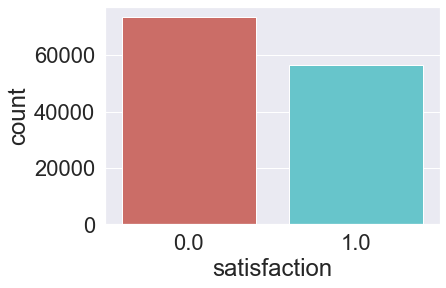

In [129]:
# check the distribution of satisfaction --> neutral or dissatisfied - 0, satisfied - 1
sb.countplot(x='satisfaction', data=scaled_df, palette='hls')
plt.show()

## Correlation Matrix

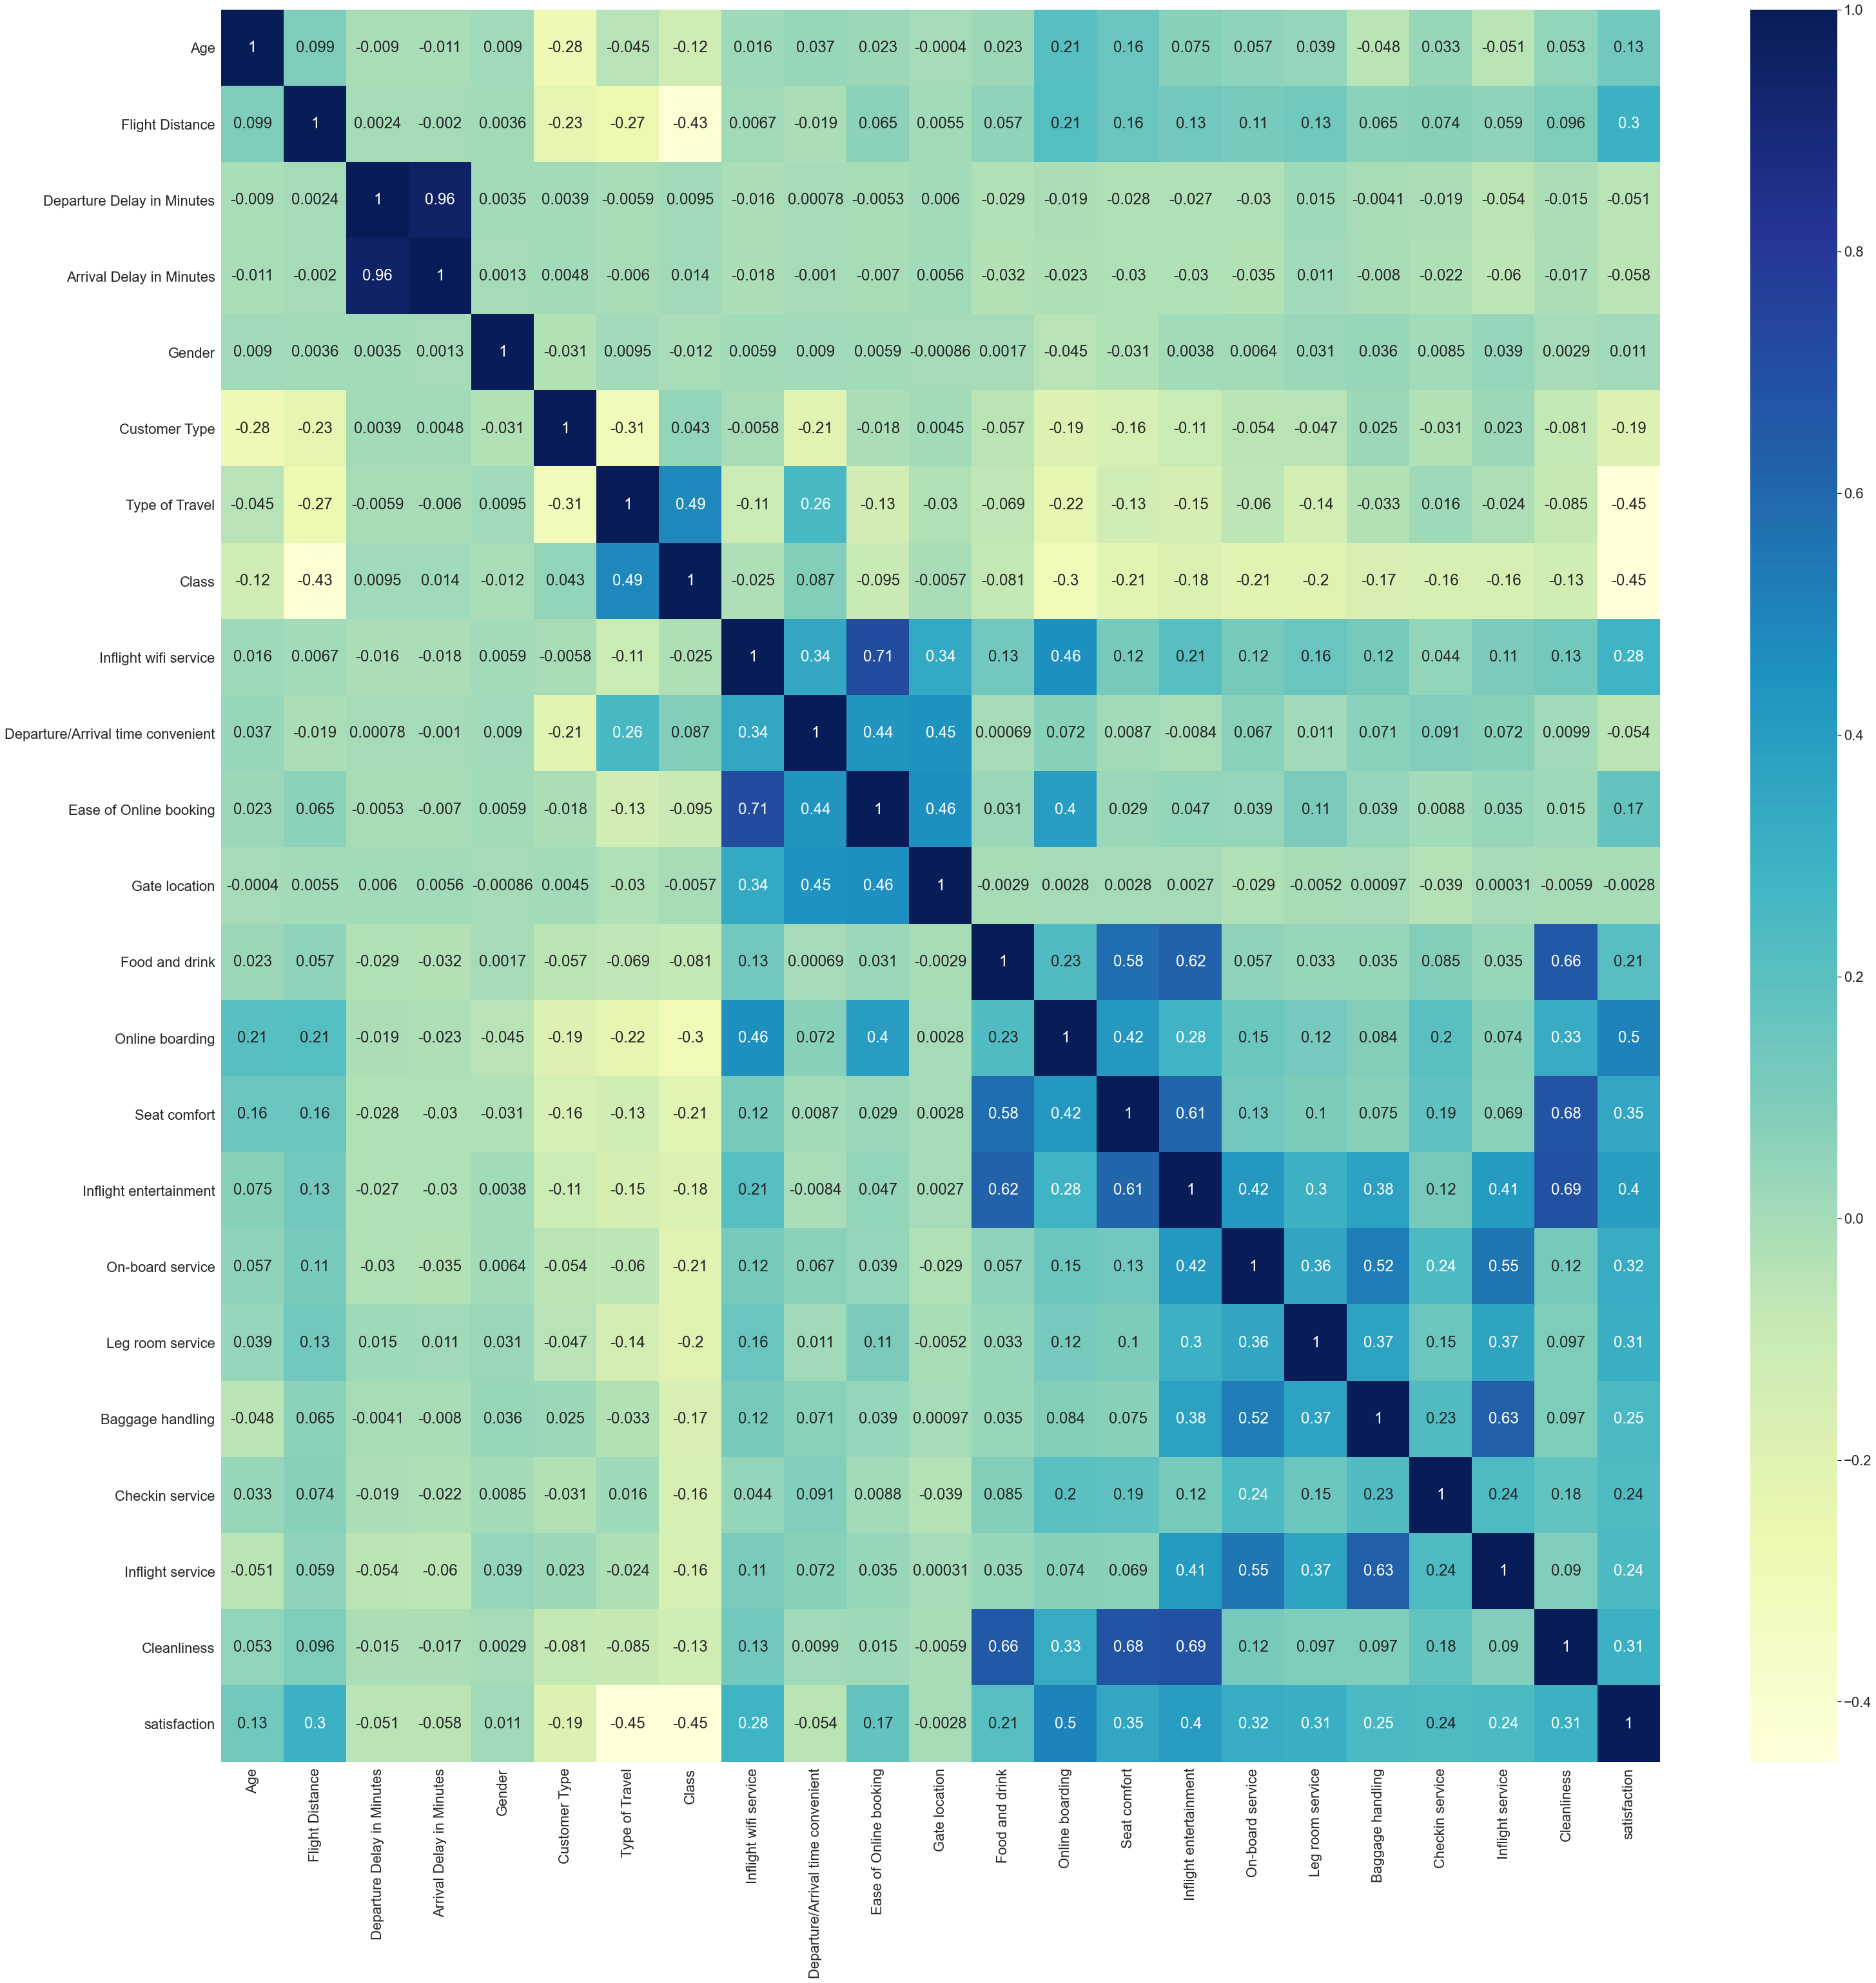

In [130]:
# correlation matrix
sb.set(font_scale=2)
plt.subplots(figsize=(50,50))
sb.heatmap(scaled_df.corr(), annot=True, cmap="YlGnBu")
plt.show()

## Distribution for Feature Category 

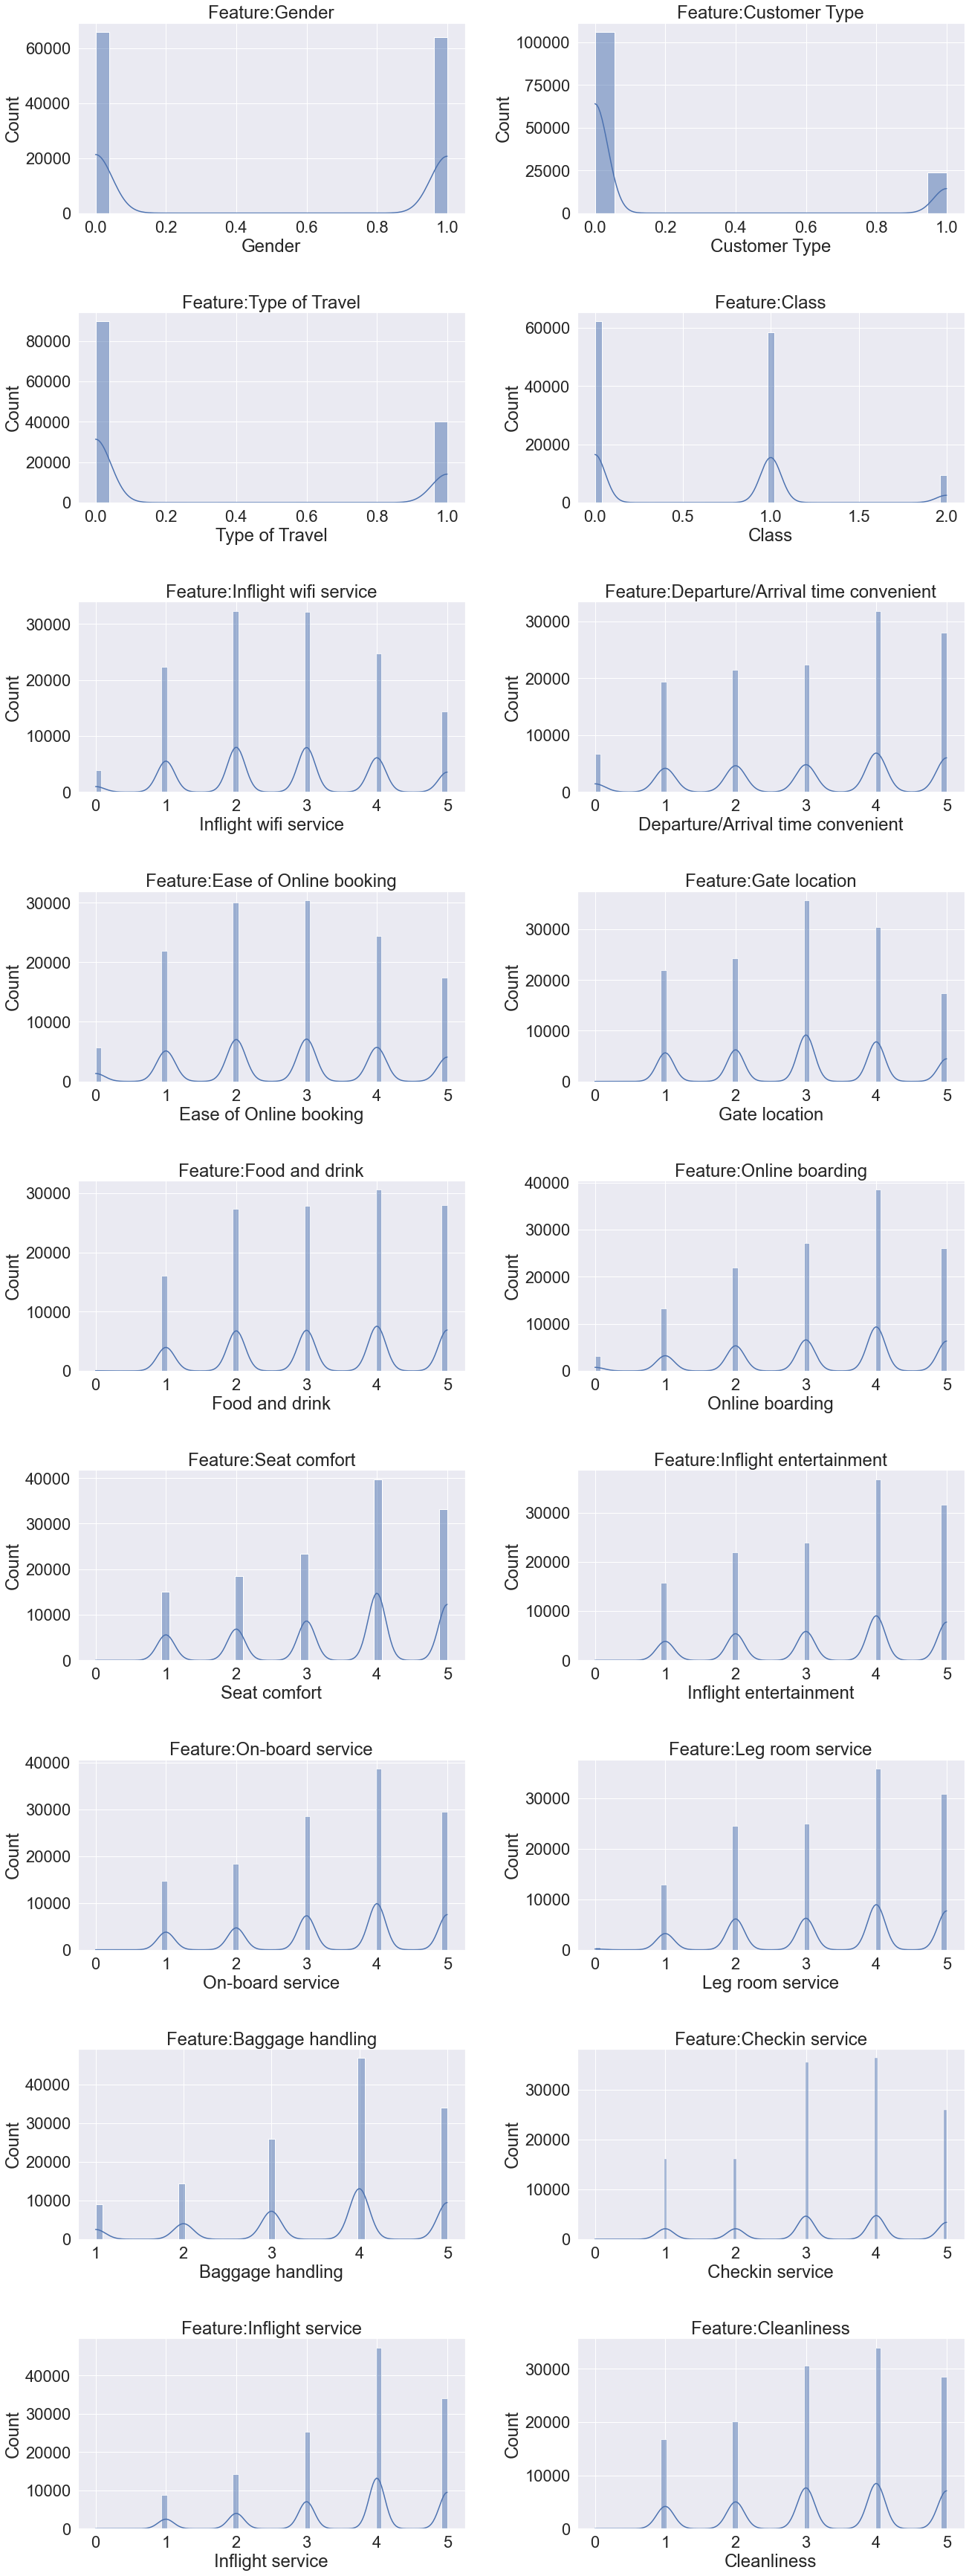

In [155]:
cat_airplaine_sat_df = scaled_df.drop(['Age', 'Flight Distance', 'Departure Delay in Minutes', 
                                       'Arrival Delay in Minutes'], axis = 1, inplace=False)

fig, axs = plt.subplots(9, 2, figsize=(20,50))
fig.tight_layout(pad=4.0)

for f, ax in zip(cat_airplaine_sat_df,axs.ravel()):
    sb.set(font_scale = 2)
    ax=sb.histplot(ax=ax,data=cat_airplaine_sat_df,x=cat_airplaine_sat_df[f],kde=True)
    ax.set_title('Feature:'+ f)

In [131]:
# split data in 80-20 train-validation sets
df_class_y = scaled_df["satisfaction"]
airplaine_sat_df_features = scaled_df.drop(labels=["satisfaction"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(airplaine_sat_df_features, df_class_y, test_size=0.20, random_state=42)

## Logistic Regression

In [145]:
k = 10 
kf = KFold(n_splits=k, shuffle=True, random_state=1)
model_lr = LogisticRegression(max_iter=500)
scores = cross_val_score(model_lr, x_train, y_train, cv=kf)
print(f"Scores on {k} runs: {scores}")
print(f"Scores: mean = {np.mean(scores)}, std dev = {np.std(scores)}")
model_lr = LogisticRegression(max_iter=500)
model_lr.fit(x_train, y_train)
y_pred = model_lr.predict(x_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100}%")

Scores on 10 runs: [0.87123472 0.87296699 0.8732557  0.87219709 0.87410972 0.87670837
 0.87690087 0.87410972 0.87237729 0.87699711]
Scores: mean = 0.8740857588593964, std dev = 0.001995871932800125
Accuracy Score: 87.61164151524484%


## Classification Report - Linear, Poly, rbf, Sigmoid

In [157]:
kernels = ['linear', 'poly','rbf', 'sigmoid']
svms = {}

for kernel in kernels:
    start = time.time()
    model_svm = SVC(kernel=kernel)
    model_svm.fit(x_train, y_train)
      # saving each classifier in a dict with kernel as its key
    svms[kernel] = model_svm
    y_pred = model_svm.predict(x_test)
    end = time.time()
    print(f"Confusion Matrix: {kernel}")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report: {kernel}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
    print(f"execution time: {end - start} seconds")
    print()

Confusion Matrix
[[13350  1272]
 [ 1918  9436]]
Classification
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     14622
         1.0       0.88      0.83      0.86     11354

    accuracy                           0.88     25976
   macro avg       0.88      0.87      0.87     25976
weighted avg       0.88      0.88      0.88     25976

Accuracy Score: 0.8771943332306744
execution time: 1752.4939522743225 seconds

Confusion Matrix
[[14087   535]
 [ 1089 10265]]
Classification
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95     14622
         1.0       0.95      0.90      0.93     11354

    accuracy                           0.94     25976
   macro avg       0.94      0.93      0.94     25976
weighted avg       0.94      0.94      0.94     25976

Accuracy Score: 0.9374807514628888
execution time: 280.56703782081604 seconds

Confusion Matrix
[[14063   559]
 [  914 10440]]
Classification

In [184]:
def get_model_report(model, x_test, y_test, \
    confusion_matrix_name="confusion_matrix", classification_report_name="confusion_matrix"):
    '''
        Calculates and saves confusion matrix and classification report for model
        model: trained model
        x_test: features for trained model to make predictions on
        y_test: labeled data for trained model to be evaluated against
        confusion_matrix_name: file name for confusion matrix
        classification_report_name: file name for classication report
    '''
    # Get predictions on Test Data
    y_pred = model.predict(x_test)
    
    # Get performance report, save as cvs
    report = classification_report(y_test, y_pred)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv('{}.csv'.format(classification_report_name), index= True)

    # Get confustion matrix, save a png
    plot_confusion_matrix(model, x_test, y_test)  
    plt.savefig('{}.png'.format(confusion_matrix_name))

In [185]:
def get_stats(model, x_test, y_test, labels=None):
    '''
        model: trained model
        x_test: features for trained model to make predictions on
        y_test: labeled data for trained model to be evaluated against
        labels: if classification is not binary, provide labels here
        returns: accuracy,recall, precision and f1 score
    '''
    #test paramaters
    y_pred = model.predict(x_test)
    recall = recall_score(y_test, y_pred, labels=labels, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=labels, average='weighted')
    f1 = f1_score(y_test, y_pred,labels=labels)
    return accuracy,recall, precision, f1

## Naive Bayes

In [180]:
def naive_bayes(x_train, y_train, x_test, y_test):
    '''
        x_train: train features
        y_train: train label
        x_test: test features
        y_test: test label
    '''
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    get_model_report(gnb, x_test, y_test, \
    confusion_matrix_name="naive_bayes_confusion", classification_report_name="naive_bayes_classification_report")

In [43]:
# TOP 1000 results
def naive_bayes_from_scratch():
    ''' 
        Implements Naive Bayes with features which are categorical
    '''
    category_features = ['Gender', 'Customer Type', 'Type of Travel', \
        'Class', 'Inflight wifi service', 'Departure/Arrival time convenient', \
            'Ease of Online booking', 'Gate location', 'Food and drink', \
                'Online boarding', 'Seat comfort', 'Inflight entertainment', \
                    'On-board service', 'Leg room service', 'Baggage handling', \
                        'Checkin service', 'Inflight service', 'Cleanliness']


    #Use naive bayes to predict is the following customer will buy a computer
    #Dont use Laplace Smoothing
    df_train =pd.read_csv("train.csv")
    
    df_test = pd.read_csv("test.csv")

    #split df for each class
    class_df = []
    classes = df_train['satisfaction'].unique()
    df_pos = df_train.loc[df_train['satisfaction'] == classes[0]]
    df_neg = df_train.loc[df_train['satisfaction'] == classes[1]]
    class_df = [df_pos, df_neg]
    N = df_pos.shape[0] + df_neg.shape[0]

    #feature probabilities in each class
    probabilities = np.zeros((len(classes), len(category_features)))
    #how likily that class is to be choosen
    class_probabilities = np.asarray([df_pos.shape[0]/N, df_neg.shape[0]/N])
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    df_test = df_test.head(1000)
    for _, test_sample in df_test.iterrows():
        count = 0
        #for each class
        for class_data in class_df:
            class_size = class_data.shape[0]
            #for each feature
            for feature_index in range(len(category_features)):
                feature_title = category_features[feature_index]
                sample_value = test_sample[feature_title]
                instances = class_data.loc[class_data[feature_title] == sample_value].count()[0]
                probabilities[count][feature_index] = instances/class_size
            count += 1
            
        #multiply probabilities of each feature together per row/class
        #eg P(Age = youth|Class=Yes) * P(Income = 'medium'| Class=Yes) * P('Student' = yes| Class=Yes)* P('Credit' = fair| Class=Yes)
        feature_prod = np.prod(probabilities, axis=1)

        #Naive Bayes p(y|x) = p(x|y)*p(y)
        class_likelihood = np.multiply(feature_prod, class_probabilities)

        #Which Class Has the Highest Likelihood?
        best_match_index = np.argmax(class_likelihood)
        match = classes[best_match_index]
        if match == test_sample.loc['satisfaction']:
            if best_match_index == 0:
                TP += 1
            else:
                TN += 1
        else:
            if best_match_index == 0:
                FP += 1
            else:
                FN += 1
                
    print("TP = {}, TN = {}, FP = {}, FN = {}".format(TP, TN, FP, FN))
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    print("The accurary of the test is {}".format(accuracy))

    precision =  TP / (TP + FP)
    recall =  TP / (TP + FN)
    print("The precision of the test is {} and the recall is {}".format(precision, recall))

    f1 = (2*precision*recall)/(precision + recall)
    print("The F1 score is {}".format(f1 ))

In [44]:
# perform Naive Bayes from scratch
naive_bayes_from_scratch()

TP = 487, TN = 399, FP = 56, FN = 58
The accurary of the test is 0.886
The precision of the test is 0.8968692449355433 and the recall is 0.8935779816513761
The F1 score is 0.8952205882352942


## Linear SVM

In [47]:
class FeatureCombo:
    def __init__(self, features, accuracy = 0, precision =0, recall =0, f1=0):
        '''
            features:
            accuracy:
            precision:
            recall:
            f1:
        '''
        self.features = features
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.f1 = f1

In [48]:
def make_meshgrid(x, y, h=.02):
    ''' 
        Make meshgrid for 2D SVM visulaization
        x: feature data
        y: label data
        return: xx and yy data
    '''
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [49]:
def plot_contours(ax, clf, xx, yy, **params):
    ''' 
        Plot contour of 2D SVM 
        ax: plot object
        clf: model object
        xx: feature data
        yy: label data
        param: plot input parameters
        return: plot result
    '''
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [51]:
def plot_3D_SVM(model, X, Y):
    ''' 
        Plot contour of 3D SVM
        model: model object
        X: features
        Y: label 
    '''
    
    z = lambda x,y: (-model.intercept_[0]-model.coef_[0][0]*x -model.coef_[0][1]*y) / model.coef_[0][2]

    tmp = np.linspace(-5,5,30)
    x,y = np.meshgrid(tmp,tmp)

    fig = plt.figure()
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot3D(X[Y==0,0], X[Y==0,1], X[Y==0,2],'ob')
    ax.plot3D(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr')
    ax.plot_surface(x, y, z(x,y))
    ax.view_init(30, 60)

In [66]:
def svm_linear(x_train, y_train, x_test, y_test, feature_names):
    '''
        x_train: train features
        y_train: train label
        x_test: test features
        y_test: test label
        return: feature_names, accuracy, precision, recall, f1
    '''
    clf = svm.SVC(kernel='linear')
    clf.fit(x_train, y_train)

    #get stats
    accuracy,recall, precision, f1 = get_stats(clf, x_test, y_test)
    print('Accuracy = {:.4f}, Recall = {:.4f}, Precision = {:.4f}, F1 = {:.4f}'.format(accuracy,recall, precision, f1))

    #plot 2D feature
    if len(feature_names) == 2:
        fig, ax = plt.subplots()
        xx, yy = make_meshgrid(x_train[:, 0], x_train[:, 1], h=.02)
        plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_ylabel(feature_names[0])
        ax.set_xlabel(feature_names[1])
        title = "2D Linear SVM with Features: {} and {}".format(feature_names[0], feature_names[1])
        ax.set_title(title)
        plt.suptitle('Accuracy {:.4f}, Recall {:.4f}, Precision {:.4f}, F1 {:.4f}'.format(accuracy,recall, precision, f1), fontsize=8)
        plt.savefig("{}.png".format(title))

    #plot 3D feature
    if len(feature_names) == 3:
        z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]
        tmp = np.linspace(-5,5,30)
        x,y = np.meshgrid(tmp,tmp)

        fig = plt.figure()
        ax  = fig.add_subplot(111, projection='3d')
        ax.plot3D(x_train[y_train==0,0], x_train[y_train==0,1], x_train[y_train==0,2],'ob')
        ax.plot3D(x_train[y_train==1,0], x_train[y_train==1,1], x_train[y_train==1,2],'sr')
        ax.plot_surface(x, y, z(x,y))
        ax.view_init(30, 60)
        title = "3D Linear SVM with Features: {}, {} and {}".format(feature_names[0], feature_names[1], feature_names[2])
        ax.set_title(title, fontsize=8)
        plt.suptitle('Accuracy {:.4f}, Recall {:.4f}, Precision {:.4f}, F1 {:.4f}'.format(accuracy, 
                                                                                recall, precision, f1), fontsize=8)
        plt.savefig("{}.png".format(title))

    return FeatureCombo(feature_names, accuracy, precision, recall, f1)

In [60]:
def svm_linear_2Features():
    ''' 
        Trains and evaluates a linear svm with 2 features
    '''
    #prep data
    df_train, df_test = load_seperate_data("train.csv", "test.csv")
    classes = df_train['satisfaction'].unique()
    sat = {classes[0]: 1,classes[1]: 0}
    df_train['satisfaction'] = [sat[item] for item in df_train['satisfaction']]
    df_test['satisfaction'] = [sat[item] for item in df_test['satisfaction']]
    y_train = df_train['satisfaction'].to_numpy()
    y_test = df_test['satisfaction'].to_numpy()


    #based off of initial distrubtions, these categories naively seem most likely to not be noisy
    #try all combinations, 
    category_to_try = ['Seat comfort', 'Online boarding', 'Leg room service', 'Inflight service', \
        'Inflight entertainment', 'Inflight wifi service']

    combos = itertools.combinations(category_to_try, 2)
    combo_results = []
    for combo in combos:
        print("Training combo {} and {}".format(combo[0] ,combo[1]))
        feature_names = [combo[0] ,combo[1]]
        x_train = df_train[[combo[0] ,combo[1]]].to_numpy()
        x_test = df_test[[combo[0] ,combo[1]]].to_numpy()
        combo_results.append(svm_linear(x_train, y_train, x_test, y_test, feature_names))

    #sort all the combos tested by accuracy            
    combo_results.sort(key=lambda x: x.accuracy)
    #print the top ten                
    for i in range(10):
        combo_features = combo_results[i].features
        print("The {}th best combo is {} and {}".format(i, combo_features[0], combo_features[1]))

Training combo Seat comfort and Online boarding
Accuracy = 0.7882, Recall = 0.7882, Precision = 0.7904, F1 = 0.8066
Training combo Seat comfort and Leg room service
Accuracy = 0.7194, Recall = 0.7194, Precision = 0.7180, F1 = 0.7590
Training combo Seat comfort and Inflight service
Accuracy = 0.7009, Recall = 0.7009, Precision = 0.7019, F1 = 0.7305
Training combo Seat comfort and Inflight entertainment
Accuracy = 0.7098, Recall = 0.7098, Precision = 0.7142, F1 = 0.7313
Training combo Seat comfort and Inflight wifi service
Accuracy = 0.6931, Recall = 0.6931, Precision = 0.6927, F1 = 0.7472
Training combo Online boarding and Leg room service
Accuracy = 0.7996, Recall = 0.7996, Precision = 0.7991, F1 = 0.8242
Training combo Online boarding and Inflight service
Accuracy = 0.8004, Recall = 0.8004, Precision = 0.8014, F1 = 0.8304
Training combo Online boarding and Inflight entertainment
Accuracy = 0.8109, Recall = 0.8109, Precision = 0.8124, F1 = 0.8396
Training combo Online boarding and Infl

KeyboardInterrupt: 

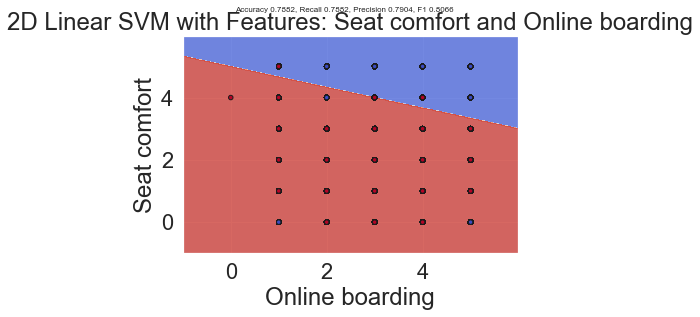

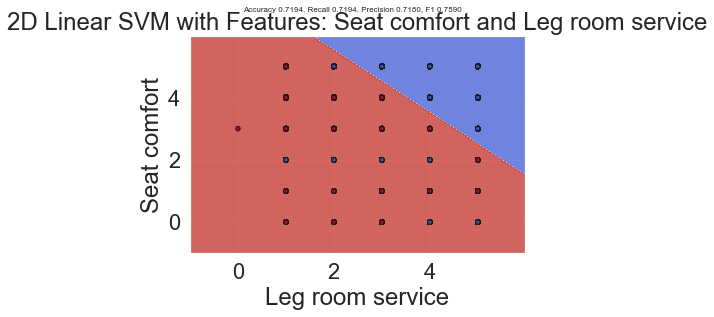

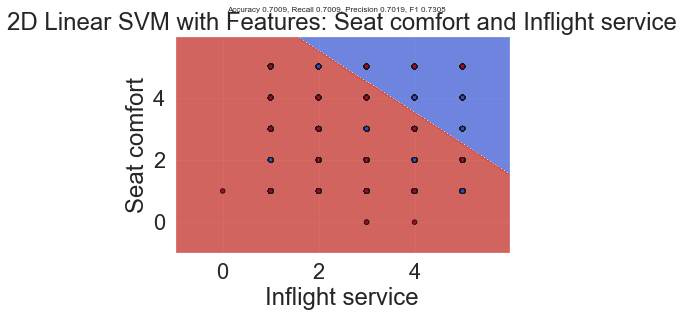

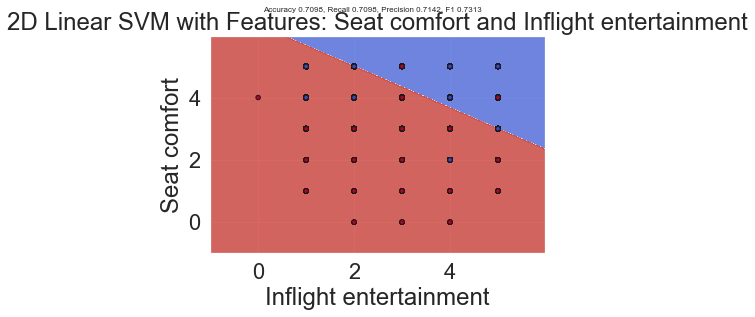

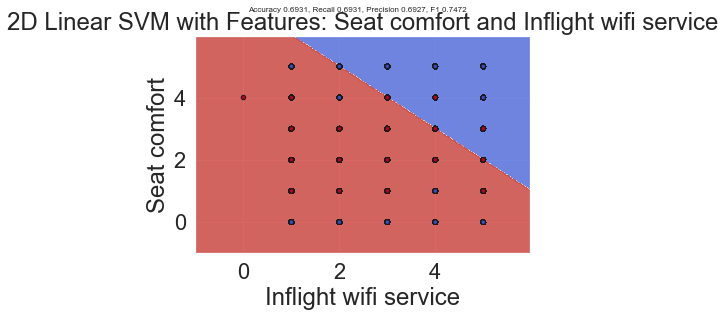

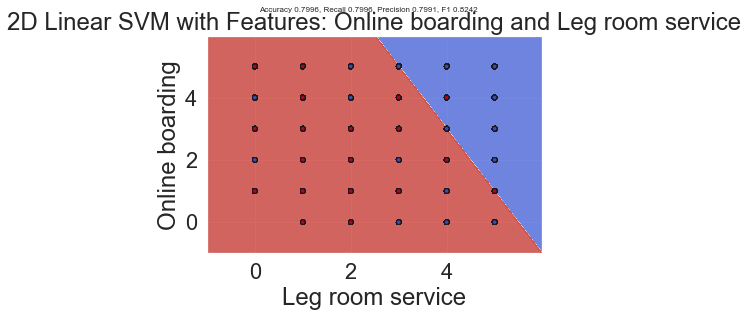

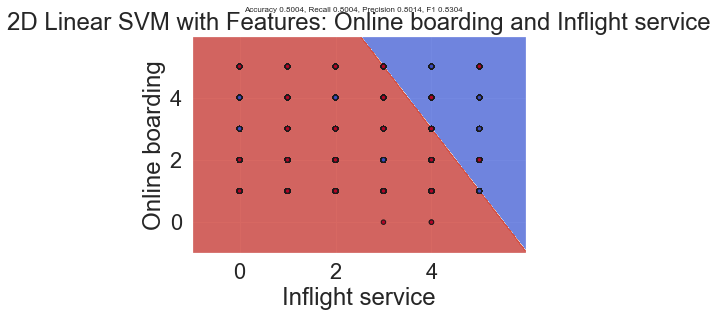

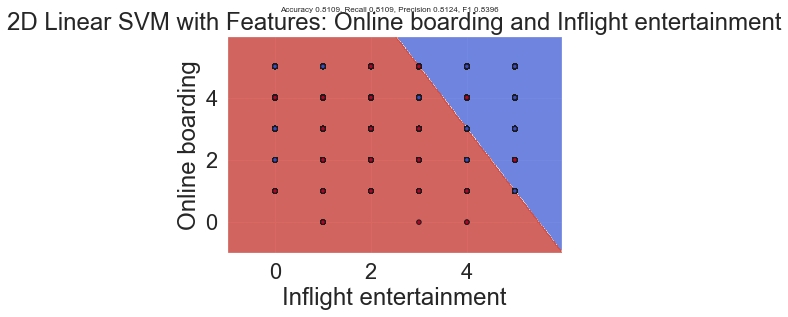

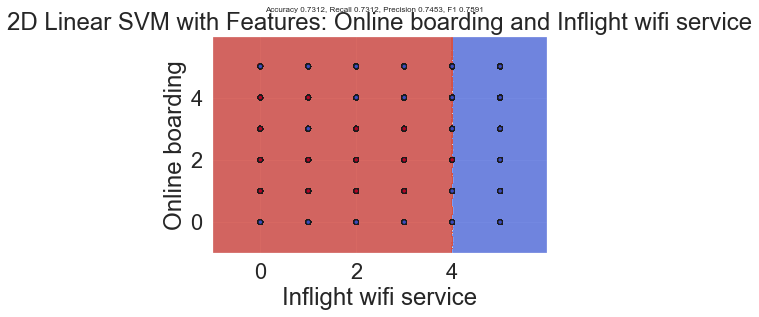

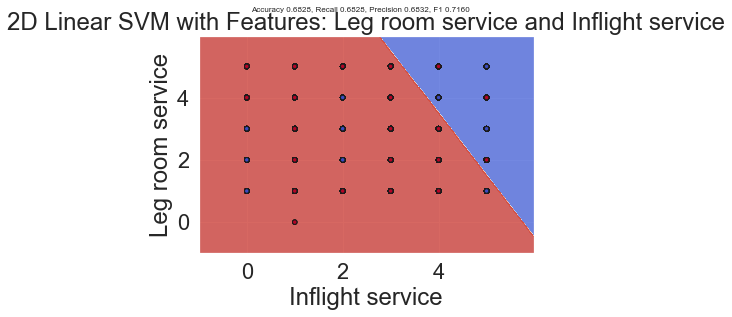

In [188]:
# linear SVM on 2 features
svm_linear_2Features()

In [61]:
def svm_linear_3Features():
    ''' 
        Trains and evaluates a linear svm with 3 features
    '''
    # The 1th best combo is Seat comfort , Inflight service and Inflight entertainment
    # The 2th best combo is Seat comfort , Inflight entertainment and Inflight wifi service
    # The 3th best combo is Leg room service , Inflight service and Inflight wifi service
    # The 4th best combo is Inflight service , Inflight entertainment and Inflight wifi service
    # The 5th best combo is Leg room service , Inflight service and Inflight entertainment
    # The 6th best combo is Seat comfort , Leg room service and Inflight service
    # The 7th best combo is Seat comfort , Leg room service and Inflight entertainment
    # The 8th best combo is Leg room service , Inflight entertainment and Inflight wifi service
    # The 9th best combo is Seat comfort , Leg room service and Inflight wifi service

    #prep data
    df_train, df_test = load_seperate_data("train.csv", "test.csv")
    classes = df_train['satisfaction'].unique()
    sat = {classes[0]: 1,classes[1]: 0}
    df_train['satisfaction'] = [sat[item] for item in df_train['satisfaction']]
    df_test['satisfaction'] = [sat[item] for item in df_test['satisfaction']]
    y_train = df_train['satisfaction'].to_numpy()
    y_test = df_test['satisfaction'].to_numpy()


    #based off of initial distrubtions, these categories naively seem most likely to not be noisy
    #try all combinations
    category_to_try = ['Seat comfort', 'Online boarding', 'Leg room service', 'Inflight service', \
        'Inflight entertainment', 'Inflight wifi service']

    combos = itertools.combinations(category_to_try, 3)
    combo_results = []
    for combo in combos:
        print("Training combo {} , {} and {}".format(combo[0] ,combo[1],combo[2]))
        feature_names = [combo[0] ,combo[1],combo[2]]
        x_train = df_train[[combo[0] ,combo[1],combo[2]]].to_numpy()
        x_test = df_test[[combo[0] ,combo[1],combo[2]]].to_numpy()
        combo_results.append(svm_linear(x_train, y_train, x_test, y_test, feature_names))

    #sort all the combos tested by accuracy            
    combo_results.sort(key=lambda x: x.accuracy)
    #print the top ten                
    for i in range(10):
        combo_features = combo_results[i].features
        print("The {}th best combo is {} , {} and {}".format(i, combo_features[0], combo_features[1], combo_features[2]))

In [ ]:
# linear SVM on 3 features
svm_linear_3Features()

In [62]:
def svm_linear_AllFeatures():
    ''' 
        Trains and evaluates a linear svm with all features
    '''
    #RESULTS: Accuracy 0.8113, Recall 0.8113, Precision 0.8110, F1 0.8360
    
     #prep data
    df_train, df_test = load_seperate_data("train.csv", "test.csv")
    classes = df_train['satisfaction'].unique()
    sat = {classes[0]: 1,classes[1]: 0}
    df_train['satisfaction'] = [sat[item] for item in df_train['satisfaction']]
    df_test['satisfaction'] = [sat[item] for item in df_test['satisfaction']]
    y_train = df_train['satisfaction'].to_numpy()
    y_test = df_test['satisfaction'].to_numpy()

    #based off of initial distrubtions, these categories naively seem most likely to not be noisy
    category_to_try = ['Seat comfort', 'Online boarding', 'Leg room service', 'Inflight service', \
        'Inflight entertainment', 'Inflight wifi service']
    x_train = df_train[category_to_try ].to_numpy()
    x_test = df_test[category_to_try ].to_numpy()
    svm_linear(x_train, y_train, x_test, y_test, category_to_try )

In [67]:
svm_linear_AllFeatures()

Accuracy = 0.8113, Recall = 0.8113, Precision = 0.8110, F1 = 0.8360


## Random Forest

In [191]:
model_rf = RandomForestClassifier()

model_rf.fit(x_train, y_train)
predict_rf = model_rf.predict(x_test)

score_train = model_rf.score(x_train, y_train)
print(f"Mean Accuracy: {score_train*100}% " )

Mean Accuracy: 99.99903757314445% 


In [192]:
# get the mean accuracy on the given test data and labels
score_test = model_rf.score(x_test, y_test)
print(f"Mean Accuracy: {score_test*100}% " )

Mean Accuracy: 96.23498614105328% 


In [193]:
# print confusion_matrix
conf_matrix = confusion_matrix(y_test, predict_rf, labels=[0, 1])

In [194]:
# show the classification report
print( f"Classification report for classifier {model_rf}:\n"
       f"{classification_report(y_test, predict_rf)}\n")

Classification report for classifier RandomForestClassifier():
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     14622
         1.0       0.98      0.94      0.96     11354

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976




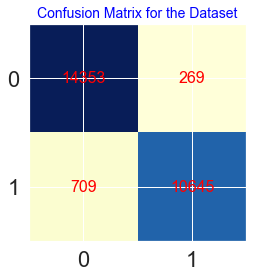

In [195]:
# plot in 2D the confusion matrix - FN, FP, TN, TP
w, h = conf_matrix.shape

plt.figure(figsize=(4,4))                  # figure size
plt.imshow(conf_matrix, cmap='YlGnBu')     # display data as an image
plt.title("Confusion Matrix for the Dataset", fontsize=14, color='blue')
plt.xticks(range(2))                      # set tick locations of the x-axis
plt.yticks(range(2))                      # set tick locations of y-axis

# loop thru the confusion matrix to print-out the values for each cell. 
for i in range(w):
    for j in range(h):
        plt.annotate(conf_matrix[i][j], xy=(j,i), horizontalalignment='center', verticalalignment='center', 
                     color='red', fontsize='16')

plt.show()

In [205]:
# for RandomizedSearchCV
# Number of trees in random forest
n_estimators = [1, 10, 100]
# Number of features to consider at every split
max_features = [2, 6, 12]
# Maximum number of levels in tree
max_depth = [2, 10, 20]
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

In [206]:
# create a grid to list the combination of hyperparameter - RandomizedSearchCV
hyperparam_grid = {'n_estimators': n_estimators, 
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf
}

# scores: precision, recall, accuracy
scorers = {'precision_score': make_scorer(precision_score, average='macro'),
           'recall_score': make_scorer(recall_score, average='macro'),
           'accuracy_score': make_scorer(accuracy_score)
}

In [207]:
# function to get the scores according to different combinations
def search_score(model, typeCV, X_train, y_train, scorers, cv, refit='precision_score'):
    '''
        model: algorithm to be use for the classification
        typeCV: the cross-validation type
        X_train: features
        y_train: label
        scorers: type of scoring
        refit: estimator using best found parameters on dataset
        return the validation classifier performance matrics
    '''
    
    print('CV - {}'.format(typeCV))
    
    if typeCV == 'RandomizedSearchCV':
        cv_search = RandomizedSearchCV(estimator=model_rf, param_distributions=hyperparam_grid, n_iter=100, 
                                         verbose=3, random_state=1, n_jobs=-1, return_train_score=True, refit=refit,
                                         scoring=scorers, cv=cv)
    else:
        # GridSearchCV
        cv_search = GridSearchCV(estimator=model_rf, param_grid=grid_hyperparam_grid, verbose=3, n_jobs=-1, 
                                 return_train_score=True, refit=refit, scoring=scorers, cv=cv)
    
    # fit the data into the model
    bp = cv_search.fit(X_train, y_train)
    
    # print the best search hyperparameter
    print('Best parameters for {}'.format(refit))
    print(bp.best_params_)
    
    return cv_search

In [208]:
# create a random forest model
cv = 3 # 5-fold cross-validation ( default value)

# perform the RandomizedSearchCV - ~4 minutes execution!
result = search_score(model_rf, 'RandomizedSearchCV', x_train, y_train, scorers, cv, refit='accuracy_score')

CV - RandomizedSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.5min finished


Best parameters for accuracy_score
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 12, 'max_depth': 20}


In [209]:
# RandomizedSearchCV_results results in dataframe
RandomizedSearchCV_results = pd.DataFrame(result.cv_results_)

# sort values by mean_test_accuracy_score in descending order
RandomizedSearchCV_results = RandomizedSearchCV_results.sort_values(by='mean_test_accuracy_score', ascending=False)

# fill with zero some NaN values at the bottom because of multiple search criteria creating NaN 
RandomizedSearchCV_results = RandomizedSearchCV_results.fillna(0)

# only capture the necessary columns
RandomizedSearchCV_results_updated = RandomizedSearchCV_results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf']].round(3)
RandomizedSearchCV_results_updated

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_n_estimators,param_max_features,param_max_depth,param_min_samples_split,param_min_samples_leaf
53,0.965,0.960,0.963,100,12,20,5,1
19,0.964,0.960,0.963,100,12,20,2,4
1,0.964,0.960,0.963,100,12,20,5,4
54,0.964,0.960,0.963,100,6,20,2,1
61,0.961,0.958,0.960,10,12,20,5,4
...,...,...,...,...,...,...,...,...
83,0.000,0.000,0.000,10,6,20,1,4
84,0.000,0.000,0.000,10,12,2,1,1
89,0.000,0.000,0.000,100,2,20,1,2
90,0.000,0.000,0.000,100,12,20,1,2


In [211]:
# for GridSearchCV - to reduce the execution time
# Number of trees in random forest
n_estimators = [1, 10, 100]
# Number of features to consider at every split
max_features = [2, 6, 12]
# Maximum number of levels in tree
max_depth = [2, 10, 20]
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

In [213]:
# create a grid to list the combination of hyperparameter - RandomizedSearchCV
hyperparam_grid = {'n_estimators': n_estimators, 
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf
}

# scores: precision, recall, accuracy
scorers = {'precision_score': make_scorer(precision_score, average='macro'),
           'recall_score': make_scorer(recall_score, average='macro'),
           'accuracy_score': make_scorer(accuracy_score)
}

In [214]:
# create a grid to list the combination of hyperparameter - for GridSearchCV to reduce the execution time
grid_hyperparam_grid = {'n_estimators': n_estimators, 
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf
}

# scores: precision, recall, accuracy
scorers = {'precision_score': make_scorer(precision_score, average='macro'),
           'recall_score': make_scorer(recall_score, average='macro'),
           'accuracy_score': make_scorer(accuracy_score)
}

In [216]:
# perform the GridSearchCV
cv = 3 # minimum value

# perform the GridSearchCV - ~8 minutes execution! (reduce the number of configuration above to reduce execution time)
result = search_score(model_rf, 'GridSearchCV', x_train, y_train, scorers, cv, refit='precision_score')

CV - GridSearchCV
Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 12.0min finished


Best parameters for precision_score
{'max_depth': 20, 'max_features': 12, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [217]:
# GridSearchCV_results results in dataframe
GridSearchCV_results = pd.DataFrame(result.cv_results_)

# sort values by mean_test_accuracy_score in descending order
GridSearchCV_results = GridSearchCV_results.sort_values(by='mean_test_accuracy_score', ascending=False)

# fill with zero some NaN values at the bottom because of multiple search criteria creating NaN 
GridSearchCV_results = GridSearchCV_results.fillna(0)

# only capture the necessary columns
GridSearchCV_results_updated = GridSearchCV_results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_n_estimators', 'param_max_features', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf']].round(3)
GridSearchCV_results_updated

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_n_estimators,param_max_features,param_max_depth,param_min_samples_split,param_min_samples_leaf
224,0.965,0.961,0.964,100,12,20,5,1
197,0.965,0.961,0.963,100,6,20,5,1
221,0.965,0.961,0.963,100,12,20,2,1
230,0.965,0.961,0.963,100,12,20,2,2
233,0.965,0.961,0.963,100,12,20,5,2
...,...,...,...,...,...,...,...,...
226,0.000,0.000,0.000,10,12,20,1,2
227,0.000,0.000,0.000,100,12,20,1,2
234,0.000,0.000,0.000,1,12,20,1,4
235,0.000,0.000,0.000,10,12,20,1,4


In [219]:
# Comparing scores: baseline, RandomizedSearchCV, GridSearchCV
base_random_forest_model = RandomForestClassifier(n_estimators=10, random_state=1) # default values
base_random_forest_model.fit(x_train, y_train)
base_accuracy = base_random_forest_model.score(x_test, y_test)

# about 1%+ difference between baseline versus RandomizedSearchCV/GridSearchCV
print("Baseline Accuracy = {:0.2f}%".format(base_accuracy*100))
print("Best RandomizedSearchCV Accuracy = {:0.2f}%".format(RandomizedSearchCV_results_updated['mean_test_accuracy_score'].max()*100))
print("Best GridSearchCV Accuracy = {:0.2f}%".format(GridSearchCV_results_updated['mean_test_accuracy_score'].max()*100))

Baseline Accuracy = 95.84%
Best RandomizedSearchCV Accuracy = 96.30%
Best GridSearchCV Accuracy = 96.40%
